### Wstęp do projektu
Celem tego projektu jest przeprowadzenie analizy rynku mieszkaniowego w Nowym Jorku dla dzielnic Manhattan, Brooklyn, Staten Island, Bronx, poprzez zestawienie ze sobą kluczowych czynników, takich jak powierzchnia, cena, oraz liczba pomieszczeń dla wybranego rodzaju nieruchomości ("CO-OP FOR SALE") znajdującego się w analizowanym datasecie.

Dataset został pobrany z serwisu kaggle.com: https://www.kaggle.com/datasets/nelgiriyewithana/new-york-housing-market


#### Import potrzebnych bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML
import folium
from folium import plugins
import statsmodels.api as sm

#### Wczytanie oraz wstępne zapoznanie się z danymi

In [2]:
# Wczytanie obrazka oraz wycentrowanie go
display(HTML('<br /><div style="text-align: center;"><img src="Images/istockphoto-615398376-612x612.jpg" alt="Alt text"></div><br />'))              
# Wczytanie danych i przypisanie ich do zmiennej nyc_data
nyc_data = pd.read_csv("NY-House-Dataset.csv")
nyc_data

# Stworzony w trakcie pracy dataset z dzielnicami które zostane wzięte do analizy.
borough = pd.read_csv("borough.csv")

In [3]:
# Kształt danych
nyc_data.shape

(4801, 17)

In [4]:
# Pierwsze informacje na temat zaimportowanych danych
nyc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4801 entries, 0 to 4800
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BROKERTITLE                  4801 non-null   object 
 1   TYPE                         4801 non-null   object 
 2   PRICE                        4801 non-null   int64  
 3   BEDS                         4801 non-null   int64  
 4   BATH                         4801 non-null   float64
 5   PROPERTYSQFT                 4801 non-null   float64
 6   ADDRESS                      4801 non-null   object 
 7   STATE                        4801 non-null   object 
 8   MAIN_ADDRESS                 4801 non-null   object 
 9   ADMINISTRATIVE_AREA_LEVEL_2  4801 non-null   object 
 10  LOCALITY                     4801 non-null   object 
 11  SUBLOCALITY                  4801 non-null   object 
 12  STREET_NAME                  4801 non-null   object 
 13  LONG_NAME         

In [5]:
# Sprawdzenie czy w danych są brakujące wartości
empty_columns = nyc_data.isnull().any(axis=0)
print("Columns with at least one blank value:\n",empty_columns)

Columns with at least one blank value:
 BROKERTITLE                    False
TYPE                           False
PRICE                          False
BEDS                           False
BATH                           False
PROPERTYSQFT                   False
ADDRESS                        False
STATE                          False
MAIN_ADDRESS                   False
ADMINISTRATIVE_AREA_LEVEL_2    False
LOCALITY                       False
SUBLOCALITY                    False
STREET_NAME                    False
LONG_NAME                      False
FORMATTED_ADDRESS              False
LATITUDE                       False
LONGITUDE                      False
dtype: bool


#### Czyszczenie oraz manipulacja danymi

Należy usunąć kolumny które nie będą nam potrzebne w analizie wczytanego datasetu.
Zamiana kolumny ze stóp kwadratowych na metry kwadratowe nieruchomości.
Usunięcie duplikatów
Przygotowanie datasetu do dalszej analizy (odrzucenie rekordów nie będących nieruchomością "CO-OP FOR SALE" oraz takich które nie znajdują się w wybranej przez nas lokalizacji: Manhattan, Brooklyn, Staten Island oraz Bronx) z wykorzystaniem przygotowanego w osobnym notebooku zbioru danych zawierających kody pocztowe oraz nazwe dzielnicy którym odpowiadają.

In [6]:
# Usunięcie kolumny pod nazwą 'BROKERTITLE'.
# Sprawdzenie czy polecenie jest wyświetlane poprawnie poprzez zastosowanie funkcji .head()

nyc_data = nyc_data.drop(columns='BROKERTITLE')
nyc_data.head(5)

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856


In [7]:
# Podmiana wartości podanych w stopach kwadratowych na metry kwadratowe oraz zmiana nazewnictwa kolumny.
nyc_data['PROPERTYSQFT'] = (nyc_data['PROPERTYSQFT']*0.09290304).round(2)
nyc_data = nyc_data.rename(columns={'PROPERTYSQFT':'PROPERTYSQMETERS'})
nyc_data.head(5)

,TYPE,PRICE,BEDS,BATH,PROPERTYSQMETERS,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Condo for sale,315000,2,2.000000,130.06,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Condo for sale,195000000,7,10.000000,1629.98,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,House for sale,260000,4,2.000000,187.20,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Condo for sale,69000,3,1.000000,41.34,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Townhouse for sale,55000000,7,2.373861,1316.90,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856


In [8]:
# Zapisanie typów nieruchomości z wielkiej litery aby uniknąć pomyłek podczas stosowania 
# (wartości mogły być pomieszane jeśli chodzi o zapis, zostało to usystematyzowane)
# Pozbycie się tych samych adresów - pozostawienie wartości unikalnych
nyc_data['TYPE'] = nyc_data['TYPE'].str.upper()
nyc_data['MAIN_ADDRESS'] = nyc_data['MAIN_ADDRESS'].drop_duplicates()
nyc_data = nyc_data.dropna()
nyc_data['STATE'] = nyc_data['STATE'].str.upper()
nyc_data.reset_index(drop = True).head(5)

,TYPE,PRICE,BEDS,BATH,PROPERTYSQMETERS,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,CONDO FOR SALE,315000,2,2.000000,130.06,2 E 55th St Unit 803,"NEW YORK, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,CONDO FOR SALE,195000000,7,10.000000,1629.98,Central Park Tower Penthouse-217 W 57th New Yo...,"NEW YORK, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,HOUSE FOR SALE,260000,4,2.000000,187.20,620 Sinclair Ave,"STATEN ISLAND, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,CONDO FOR SALE,69000,3,1.000000,41.34,2 E 55th St Unit 908W33,"MANHATTAN, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,TOWNHOUSE FOR SALE,55000000,7,2.373861,1316.90,5 E 64th St,"NEW YORK, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856


In [9]:
nyc_data['TYPE'].value_counts()

TYPE
CO-OP FOR SALE                1388
HOUSE FOR SALE                 965
CONDO FOR SALE                 842
MULTI-FAMILY HOME FOR SALE     697
TOWNHOUSE FOR SALE             287
PENDING                        229
CONTINGENT                      87
LAND FOR SALE                   47
FOR SALE                        20
FORECLOSURE                     14
CONDOP FOR SALE                  4
COMING SOON                      2
MOBILE HOUSE FOR SALE            1
Name: count, dtype: int64

In [10]:
# Ze stworzonego wczesniej datasetu wyodrębiam kody pocztowe do pożądanych przeze mnie dzielnic
borough = borough[borough['BOROUGH'] != 'Queens']
l = list(borough['ZIP CODE'])
location = [str(ZIP) for ZIP in l]

In [11]:
# Stworzenie datasetu który zawiera tylko nieruchomość 'CO-OP FOR SALE' oraz kopii df który będzie używany do dalszych analiz
coop = ['CO-OP FOR SALE']
df = nyc_data[nyc_data["TYPE"].isin(coop)]
df_copy = df.copy()

In [12]:
# Zostawienie w kolumnie STATE tylko samych kodów pocztowych oraz przefiltrowanie danych przez żądaną lokalizację
df['STATE'] = df['STATE'].str.extract(r'(\d{5})')
df = df[df["STATE"].isin(location)]

/var/folders/1f/2_y33jss4n75vrx4ryshkwnc0000gn/T/ipykernel_1923/4034283856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['STATE'] = df['STATE'].str.extract(r'(\d{5})')


In [13]:
df.reset_index(drop = True).head(3)

,TYPE,PRICE,BEDS,BATH,PROPERTYSQMETERS,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,CO-OP FOR SALE,265000,1,1.0,69.68,875 Morrison Ave Apt 3M,10473,"875 Morrison Ave Apt 3MBronx, NY 10473",Bronx County,The Bronx,East Bronx,Morrison Avenue,Parking lot,"Parking lot, 875 Morrison Ave #3m, Bronx, NY 1...",40.821586,-73.874089
1,CO-OP FOR SALE,440000,2,1.0,90.86,1350 Ocean Pkwy Apt 5G,11230,"1350 Ocean Pkwy Apt 5GBrooklyn, NY 11230",New York,Kings County,Brooklyn,Midwood,1350,"1350 Ocean Pkwy #5g, Brooklyn, NY 11230, USA",40.615738,-73.969694
2,CO-OP FOR SALE,375000,2,1.0,78.97,800 Grand Concourse Apt 2JS,10451,"800 Grand Concourse Apt 2JSBronx, NY 10451",New York,Bronx County,The Bronx,Concourse Village,800,"800 Grand Concourse #2j, Bronx, NY 10451, USA",40.824870,-73.922983


#### Stosunek ceny do metra kwadratowego nieruchomości

Aby sprawdzić stosunek ceny do metra kwadratowego nieruchomości należy obliczyc średnią oraz odchylenie standardowe dla kolumny "PRICE", dzięki temu będziemy mogli pozbyć się wartości odstających.
Wykres narysować za pomocą polecenia 'scatter'.

In [14]:
# Obliczenie średniej, odchylenia standardowego, minimalnej oraz maksymalnej wartości dla wybranych kolumn.
# Daje nam to generalny pogląd jak rozkładają się dane.
df_f = df[['PRICE','BEDS','BATH','PROPERTYSQMETERS']]
df_f.describe()

,PRICE,BEDS,BATH,PROPERTYSQMETERS
count,9.010000e+02,901.000000,901.000000,901.000000
mean,1.218831e+06,2.033296,1.487921,150.862075
std,2.745813e+06,0.980363,0.864558,75.467399
min,4.950000e+04,1.000000,1.000000,23.230000
25%,3.000000e+05,1.000000,1.000000,79.620000
50%,5.450000e+05,2.000000,1.000000,202.920000
75%,9.990000e+05,3.000000,2.000000,202.920000
max,4.800000e+07,6.000000,8.000000,696.770000


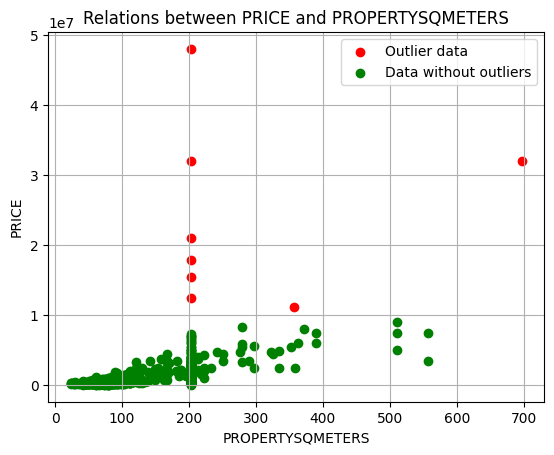

In [15]:
# Obliczenie odchylenia standardowego dla cen
mean_price = df['PRICE'].mean()
std_dev_price = df['PRICE'].std()

# Kryterium 3 sigma dla danych odstających
criterion = mean_price + 3 * std_dev_price

# Indeksy danych odstających
outliers_indices = df[df['PRICE'] > criterion].index

# Wyszczególnienie danych odstających
plt.scatter(df.loc[outliers_indices, 'PROPERTYSQMETERS'], df.loc[outliers_indices, 'PRICE'], color='red', label='Outlier data')

# Usunięcie danych odstających
df_filtered = df.drop(outliers_indices)
plt.scatter(df_filtered['PROPERTYSQMETERS'], df_filtered['PRICE'], color='green', label='Data without outliers')

# Dodanie tytułu i etykiet osi
plt.title('Relations between PRICE and PROPERTYSQMETERS')
plt.xlabel('PROPERTYSQMETERS')
plt.ylabel('PRICE')
plt.legend()
plt.grid(True)
plt.show()


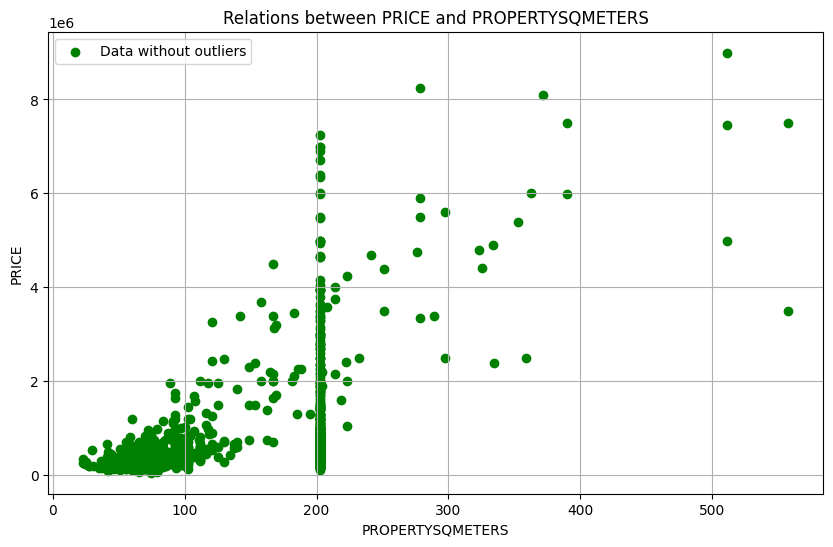

In [16]:
# Przedstawienie wyników pomijając wartości odstające.
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['PROPERTYSQMETERS'], df_filtered['PRICE'], color='green', label='Data without outliers')
plt.grid(True)
plt.title('Relations between PRICE and PROPERTYSQMETERS')
plt.xlabel('PROPERTYSQMETERS')
plt.ylabel('PRICE')
plt.legend()
plt.show()

In [17]:
# Zliczenie ile wartości jest w danych metrażach 
df['PROPERTYSQMETERS'].value_counts()

PROPERTYSQMETERS
202.92    421
74.32      33
69.68      29
83.61      27
78.97      24
         ... 
93.83       1
76.37       1
79.34       1
66.89       1
275.83      1
Name: count, Length: 174, dtype: int64

#### Średnia cena nieruchomości w konkretnej dzielnicy

Należy wygenerować zbiór dzielnic Nowego Jorku, które są przez nasz porządane - odrzucić należy Queens.
Trzeba przefiltrować nieruchomości przez żądany zbiór dzielnic, zostawiając tylko te które nas interesują.
W następnej kolejności za pomocą funkcji 'mean()' należy obliczyć średnią cenę nieruchomości oraz pogrupować to do odpowiednich dzielnic. 

In [18]:
state = borough['BOROUGH'][borough['BOROUGH'] != 'Queens']
st = list(set(borough['BOROUGH']))
b = [str(B) for B in st]
b
STATE = []
for element in b:
    STATE.append(element.upper())
STATE

['MANHATTAN', 'BROOKLYN', 'BRONX', 'STATEN ISLAND']

In [19]:
df_borough = df_copy
df_borough['STATE'] = df_borough['STATE'].str.split(',').str[0]
df_borough = df_borough[df_borough["STATE"].isin(STATE)]
df_borough.reset_index(drop=True).head(3)

,TYPE,PRICE,BEDS,BATH,PROPERTYSQMETERS,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,CO-OP FOR SALE,265000,1,1.0,69.68,875 Morrison Ave Apt 3M,BRONX,"875 Morrison Ave Apt 3MBronx, NY 10473",Bronx County,The Bronx,East Bronx,Morrison Avenue,Parking lot,"Parking lot, 875 Morrison Ave #3m, Bronx, NY 1...",40.821586,-73.874089
1,CO-OP FOR SALE,440000,2,1.0,90.86,1350 Ocean Pkwy Apt 5G,BROOKLYN,"1350 Ocean Pkwy Apt 5GBrooklyn, NY 11230",New York,Kings County,Brooklyn,Midwood,1350,"1350 Ocean Pkwy #5g, Brooklyn, NY 11230, USA",40.615738,-73.969694
2,CO-OP FOR SALE,375000,2,1.0,78.97,800 Grand Concourse Apt 2JS,BRONX,"800 Grand Concourse Apt 2JSBronx, NY 10451",New York,Bronx County,The Bronx,Concourse Village,800,"800 Grand Concourse #2j, Bronx, NY 10451, USA",40.824870,-73.922983


In [20]:
# Średnia cena nieruchomości w zależności od dzielnicy
df_borough
average_prices = df_borough.groupby('STATE')['PRICE'].mean().reset_index()
average_prices = average_prices.rename(columns={'PRICE': 'AVERAGE PRICE - USD'})
av_prices = average_prices.copy()
av_prices['AVERAGE PRICE - USD'] = average_prices['AVERAGE PRICE - USD'].apply(lambda x: '{:,.2f}'.format(x))
av_prices

,STATE,AVERAGE PRICE - USD
0,BRONX,"286,139.89"
1,BROOKLYN,"456,990.21"
2,MANHATTAN,"1,973,630.90"
3,STATEN ISLAND,"333,625.00"


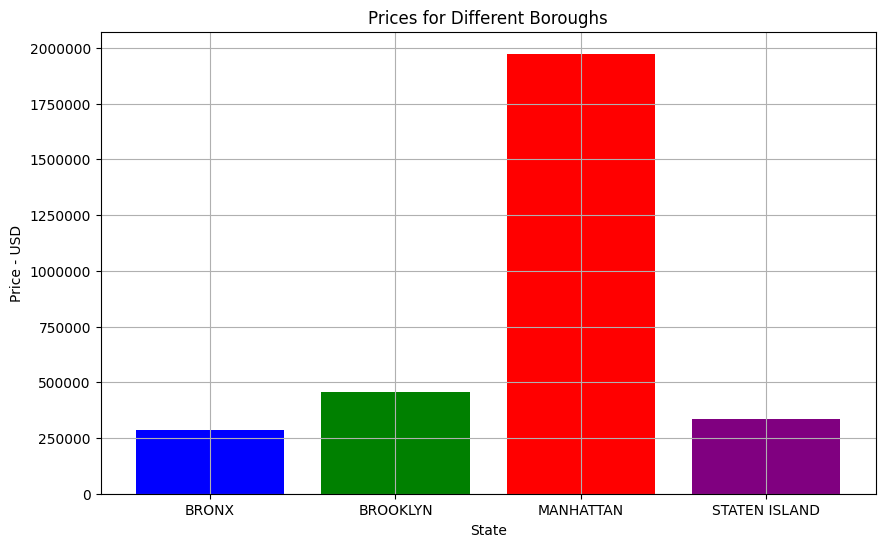

In [42]:
plt.figure(figsize=(10, 6))
plt.bar(average_prices['STATE'], average_prices['AVERAGE PRICE - USD'], color=['blue', 'green', 'red', 'purple'])
plt.xlabel('State')
plt.ylabel('Price - USD')
plt.title('Prices for Different Boroughs')
plt.grid()
plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### Stosunek ilości pomieszczeń do ceny za metr kwadratowy nieruchomości

Podczas sprawdzenia stosunku ilości pomieszczeń do ceny za metr kwadratowy nieruchomości należy stworzyć odpowiednią nową kolumnę która zawiera sumę z kolumn BEDS oraz BATH.
Należy stworzyć nową kolumnę która będzie przedstawiała cenę za metr kwadratowy danej nieruchomości, osiągniemy to dzieląć kolumne PRICE przez PROPERTYSQMETERS.
Należy obliczyć średnią cenę za metr oraz odchylenie standardowe, dzięki temu będziemy mogli pozbyć się wartości odstających.
Za pomocą regresji liniowej będziemy mogli zbadać trend czy wraz z wzrostem ilości pomieszczeń cena za metr kwadratowy nieruchomości wzrasta czy maleje.

In [22]:
# Przypisanie datasetu do zmiennej df_room.
df_room = df_copy.reset_index(drop=True)
df_room

,TYPE,PRICE,BEDS,BATH,PROPERTYSQMETERS,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,CO-OP FOR SALE,265000,1,1.0,69.68,875 Morrison Ave Apt 3M,BRONX,"875 Morrison Ave Apt 3MBronx, NY 10473",Bronx County,The Bronx,East Bronx,Morrison Avenue,Parking lot,"Parking lot, 875 Morrison Ave #3m, Bronx, NY 1...",40.821586,-73.874089
1,CO-OP FOR SALE,440000,2,1.0,90.86,1350 Ocean Pkwy Apt 5G,BROOKLYN,"1350 Ocean Pkwy Apt 5GBrooklyn, NY 11230",New York,Kings County,Brooklyn,Midwood,1350,"1350 Ocean Pkwy #5g, Brooklyn, NY 11230, USA",40.615738,-73.969694
2,CO-OP FOR SALE,375000,2,1.0,78.97,800 Grand Concourse Apt 2JS,BRONX,"800 Grand Concourse Apt 2JSBronx, NY 10451",New York,Bronx County,The Bronx,Concourse Village,800,"800 Grand Concourse #2j, Bronx, NY 10451, USA",40.824870,-73.922983
3,CO-OP FOR SALE,259000,3,1.0,202.92,34-41 85th St Unit 1D,JACKSON HEIGHTS,"34-41 85th St Unit 1DJackson Heights, NY 11372",New York,Queens County,Queens,Flushing,34-41,"34-41 85th St #1b, Flushing, NY 11372, USA",40.753119,-73.881876
4,CO-OP FOR SALE,430000,2,2.0,202.92,91-15 Lamont Ave Unit 6D,ELMHURST,"91-15 Lamont Ave Unit 6DElmhurst, NY 11373",New York,Queens County,Queens,Elmhurst,91-15,"91-15 Lamont Ave #6d, Elmhurst, NY 11373, USA",40.743864,-73.874572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,CO-OP FOR SALE,1950000,2,4.0,202.92,700 Park Ave Unit 20A,NEW YORK,"700 Park Ave Unit 20ANew York, NY 10021",New York,New York County,New York,Manhattan,700,"700 Park Ave #20a, New York, NY 10021, USA",40.769478,-73.965389
1384,CO-OP FOR SALE,599000,1,1.0,202.92,222 E 80th St Apt 3A,MANHATTAN,"222 E 80th St Apt 3AManhattan, NY 10075",New York,New York County,New York,Manhattan,222,"222 E 80th St #3a, New York, NY 10075, USA",40.774350,-73.955879
1385,CO-OP FOR SALE,245000,1,1.0,202.92,97-40 62 Dr Unit Lg,REGO PARK,"97-40 62 Dr Unit LgRego Park, NY 11374",United States,New York,Queens County,Queens,62nd Drive,"97-40 62nd Dr, Rego Park, NY 11374, USA",40.732538,-73.860152
1386,CO-OP FOR SALE,1275000,1,1.0,202.92,427 W 21st St Unit Garden,NEW YORK,"427 W 21st St Unit GardenNew York, NY 10011",United States,New York,New York County,New York,West 21st Street,"427 W 21st St, New York, NY 10011, USA",40.745882,-74.003398


In [23]:
# Tworzymy nową kolumne w której dodajemy ilość pokoi i łazienek, dodajemy do datasetu. 
df_room['TOTAL_ROOMS'] = df_room['BATH'] + df_room['BEDS']
df_room.head()

,TYPE,PRICE,BEDS,BATH,PROPERTYSQMETERS,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE,TOTAL_ROOMS
0,CO-OP FOR SALE,265000,1,1.0,69.68,875 Morrison Ave Apt 3M,BRONX,"875 Morrison Ave Apt 3MBronx, NY 10473",Bronx County,The Bronx,East Bronx,Morrison Avenue,Parking lot,"Parking lot, 875 Morrison Ave #3m, Bronx, NY 1...",40.821586,-73.874089,2.0
1,CO-OP FOR SALE,440000,2,1.0,90.86,1350 Ocean Pkwy Apt 5G,BROOKLYN,"1350 Ocean Pkwy Apt 5GBrooklyn, NY 11230",New York,Kings County,Brooklyn,Midwood,1350,"1350 Ocean Pkwy #5g, Brooklyn, NY 11230, USA",40.615738,-73.969694,3.0
2,CO-OP FOR SALE,375000,2,1.0,78.97,800 Grand Concourse Apt 2JS,BRONX,"800 Grand Concourse Apt 2JSBronx, NY 10451",New York,Bronx County,The Bronx,Concourse Village,800,"800 Grand Concourse #2j, Bronx, NY 10451, USA",40.824870,-73.922983,3.0
3,CO-OP FOR SALE,259000,3,1.0,202.92,34-41 85th St Unit 1D,JACKSON HEIGHTS,"34-41 85th St Unit 1DJackson Heights, NY 11372",New York,Queens County,Queens,Flushing,34-41,"34-41 85th St #1b, Flushing, NY 11372, USA",40.753119,-73.881876,4.0
4,CO-OP FOR SALE,430000,2,2.0,202.92,91-15 Lamont Ave Unit 6D,ELMHURST,"91-15 Lamont Ave Unit 6DElmhurst, NY 11373",New York,Queens County,Queens,Elmhurst,91-15,"91-15 Lamont Ave #6d, Elmhurst, NY 11373, USA",40.743864,-73.874572,4.0


In [24]:
# Tworzenie nowej kolumny w która posiada cene za metr kwadratowy nieruchomości
df_room['DIVIDE_PRICETOSQ'] = df_room['PRICE']/df_room['PROPERTYSQMETERS']
df_room['DIVIDE_PRICETOSQ']

0       3803.099885
1       4842.615012
2       4748.638724
3       1276.365070
4       2119.061699
           ...     
1383    9609.698403
1384    2951.902227
1385    1207.372363
1386    6283.264341
1387    5008.610792
Name: DIVIDE_PRICETOSQ, Length: 1388, dtype: float64

In [25]:
df_room.head()

,TYPE,PRICE,BEDS,BATH,PROPERTYSQMETERS,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE,TOTAL_ROOMS,DIVIDE_PRICETOSQ
0,CO-OP FOR SALE,265000,1,1.0,69.68,875 Morrison Ave Apt 3M,BRONX,"875 Morrison Ave Apt 3MBronx, NY 10473",Bronx County,The Bronx,East Bronx,Morrison Avenue,Parking lot,"Parking lot, 875 Morrison Ave #3m, Bronx, NY 1...",40.821586,-73.874089,2.0,3803.099885
1,CO-OP FOR SALE,440000,2,1.0,90.86,1350 Ocean Pkwy Apt 5G,BROOKLYN,"1350 Ocean Pkwy Apt 5GBrooklyn, NY 11230",New York,Kings County,Brooklyn,Midwood,1350,"1350 Ocean Pkwy #5g, Brooklyn, NY 11230, USA",40.615738,-73.969694,3.0,4842.615012
2,CO-OP FOR SALE,375000,2,1.0,78.97,800 Grand Concourse Apt 2JS,BRONX,"800 Grand Concourse Apt 2JSBronx, NY 10451",New York,Bronx County,The Bronx,Concourse Village,800,"800 Grand Concourse #2j, Bronx, NY 10451, USA",40.824870,-73.922983,3.0,4748.638724
3,CO-OP FOR SALE,259000,3,1.0,202.92,34-41 85th St Unit 1D,JACKSON HEIGHTS,"34-41 85th St Unit 1DJackson Heights, NY 11372",New York,Queens County,Queens,Flushing,34-41,"34-41 85th St #1b, Flushing, NY 11372, USA",40.753119,-73.881876,4.0,1276.365070
4,CO-OP FOR SALE,430000,2,2.0,202.92,91-15 Lamont Ave Unit 6D,ELMHURST,"91-15 Lamont Ave Unit 6DElmhurst, NY 11373",New York,Queens County,Queens,Elmhurst,91-15,"91-15 Lamont Ave #6d, Elmhurst, NY 11373, USA",40.743864,-73.874572,4.0,2119.061699


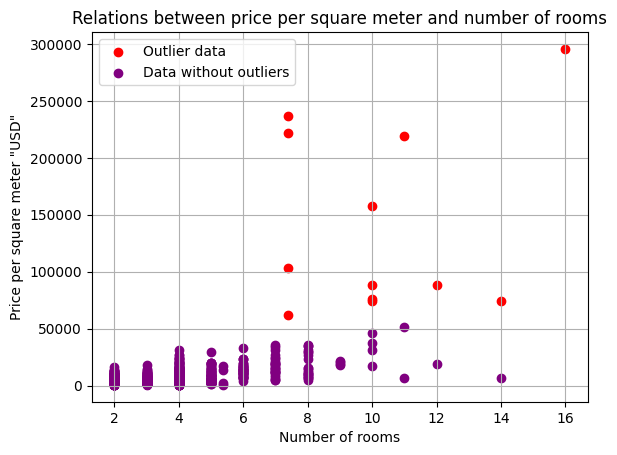

In [26]:
# Obliczenie odchylenia standardowego dla cen
mean_divideprice = df_room['DIVIDE_PRICETOSQ'].mean()
std_dev_divideprice = df_room['DIVIDE_PRICETOSQ'].std()

# Kryterium 3 sigma dla danych odstających
criterion_3s = mean_divideprice + 3 * std_dev_divideprice

# Indeksy danych odstających
outliers_price = df_room[df_room['DIVIDE_PRICETOSQ'] > criterion_3s].index

# Wyszczególnienie danych odstających
plt.scatter(df_room.loc[outliers_price, 'TOTAL_ROOMS'], df_room.loc[outliers_price, 'DIVIDE_PRICETOSQ'], color='red', label='Outlier data')

# Usunięcie danych odstających
df_filt = df_room.drop(outliers_price)
plt.scatter(df_filt['TOTAL_ROOMS'], df_filt['DIVIDE_PRICETOSQ'], color='purple', label='Data without outliers')


# Dodanie tytułu i etykiet osi
plt.title('Relations between price per square meter and number of rooms')
plt.xlabel('Number of rooms')
plt.ylabel('Price per square meter "USD"')
plt.legend()
plt.grid(True)
plt.show()

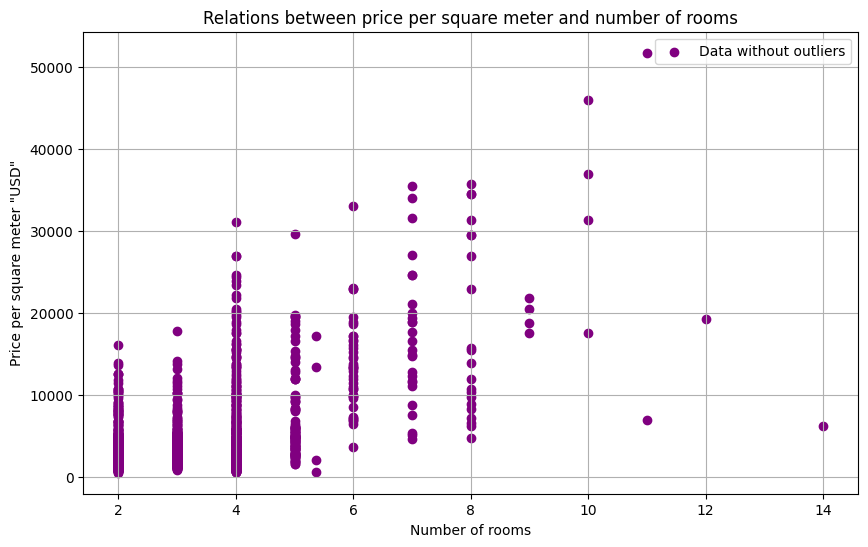

In [27]:
# Przedstawienie wyników pomijając wartości odstające.
plt.figure(figsize=(10, 6))
plt.scatter(df_filt['TOTAL_ROOMS'], df_filt['DIVIDE_PRICETOSQ'], color='purple', label='Data without outliers')
plt.grid(True)
plt.title('Relations between price per square meter and number of rooms')
plt.xlabel('Number of rooms')
plt.ylabel('Price per square meter "USD"')
plt.legend()
plt.show()

In [28]:
X = df_filt['TOTAL_ROOMS']  # Niezależna zmienna (liczba pomieszczeń)
Y = df_filt['DIVIDE_PRICETOSQ']  # Zależna zmienna (cena za metr kwadratowy)

# Dodanie stałej do modelu (intercept)
X = sm.add_constant(X)

# Dopasowanie modelu regresji liniowej
model = sm.OLS(Y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       DIVIDE_PRICETOSQ   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     695.3
Date:                Fri, 21 Jun 2024   Prob (F-statistic):          2.52e-124
Time:                        11:51:51   Log-Likelihood:                -13541.
No. Observations:                1376   AIC:                         2.709e+04
Df Residuals:                    1374   BIC:                         2.710e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1826.0236    300.303     -6.081      

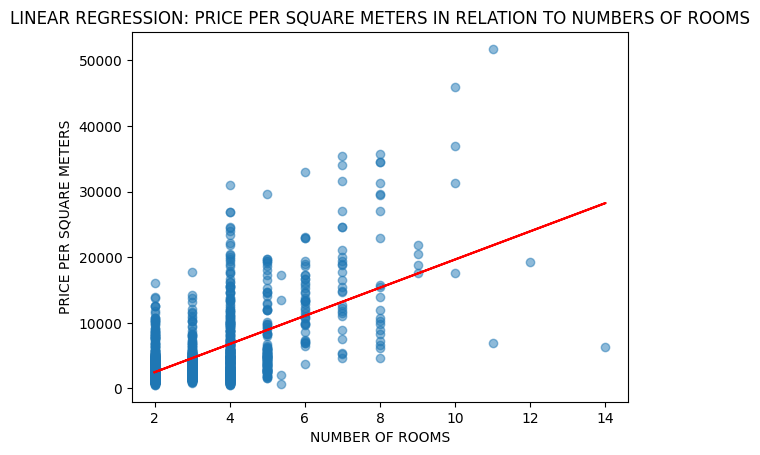

In [29]:
# Wykres danych z zadaną częściowo przezroczystością poprzez współczynnik alpha.
plt.scatter(X['TOTAL_ROOMS'], Y, alpha=0.5)

# Wykres linii regresji
plt.plot(X['TOTAL_ROOMS'], model.predict(X), color='red')

plt.title('LINEAR REGRESSION: PRICE PER SQUARE METERS IN RELATION TO NUMBERS OF ROOMS')
plt.xlabel('NUMBER OF ROOMS')
plt.ylabel('PRICE PER SQUARE METERS')
plt.show()

In [30]:
# Obliczenie średniej ceny za metr kwadratowy i średniej ilości pomieszczeń w konkretnej dzielnicy
df_filt # dane z odrzuconymi wynikami odstającymi
cols = ['STATE', 'DIVIDE_PRICETOSQ', 'TOTAL_ROOMS']
df_choosen_cols = df_room[cols]

grouped_data = df_choosen_cols.groupby('STATE')

# Obliczenie średniej ceny za metr kwadratowy i średniej liczby pomieszczeń dla każdej dzielnicy
average_data = grouped_data.mean().round(2)
filt_data = average_data.loc[STATE] # STATE - lista została stworzona przy filtrowaniu ceny nieruchomości w konkretnej dzielnicy.

print(filt_data)

               DIVIDE_PRICETOSQ  TOTAL_ROOMS
STATE                                       
MANHATTAN              10129.41         4.07
BROOKLYN                4607.82         2.88
BRONX                   2832.62         3.03
STATEN ISLAND           3651.39         2.50


#### Mapa Nowego Jorku z podziałem nieruchomości pod względem ceny

Za pomocą biblioteki folium tworzymy mapę Nowego Jorku.
Należy wykonać funkcję, która przypisze odpowiedni kolor do odpowiedniej ceny nieruchomości.
Z wykorzystaniem kolumn "LATITUDE" oraz "LONGITUDE" jak również ze stworzoną wcześniej funkcją wyboru koloru należy nanieść wszystko na mapę za pomocą funkcji CircleMarker.
Do mapy dodać legendę.

In [31]:
# Stworzenie mapy Nowego Jorku
nyc_map = folium.Map(location=[40.7128, -74.0006], zoom_start=11)

# Przypisanie kolorów do różnych zakresów cen
def pick_color(price):
    if price <= 500000:
        return 'blue'
    elif price <= 1000000:
        return 'green'
    elif price <= 5000000:
        return 'red'
    else:
        return 'orange'

# Dodanie znaczników dla każdej nieruchomości z przypisanymi kolorami
for _, row in df.iterrows():
    tooltip_text = f"{row['TYPE']}: {row['PRICE']} - USD" 
    color = pick_color(row['PRICE'])
    folium.CircleMarker(location=(row['LATITUDE'], row['LONGITUDE']), popup=row['MAIN_ADDRESS'], tooltip=tooltip_text, radius=5, color=color, fill=True, fill_color=color).add_to(nyc_map)

legend = 'Property Price Legend:'
legend += '<br> 0 - 500 000 USD: <span style="color:blue"> O </span>'
legend += '<br> 500 001 - 1 000 000 USD: <span style="color:green"> O </span>'
legend += '<br> 1 000 001 - 5 000 000 USD: <span style="color:red"> O </span>'
legend += '<br> Above 5 000 000: <span style="color:orange"> O </span>'
nyc_map.get_root().html.add_child(folium.Element(legend))

nyc_map

### Wyniki oraz przedstawienie graficzne wyników

#### Stosunek ceny do metra kwadratowego nieruchomości

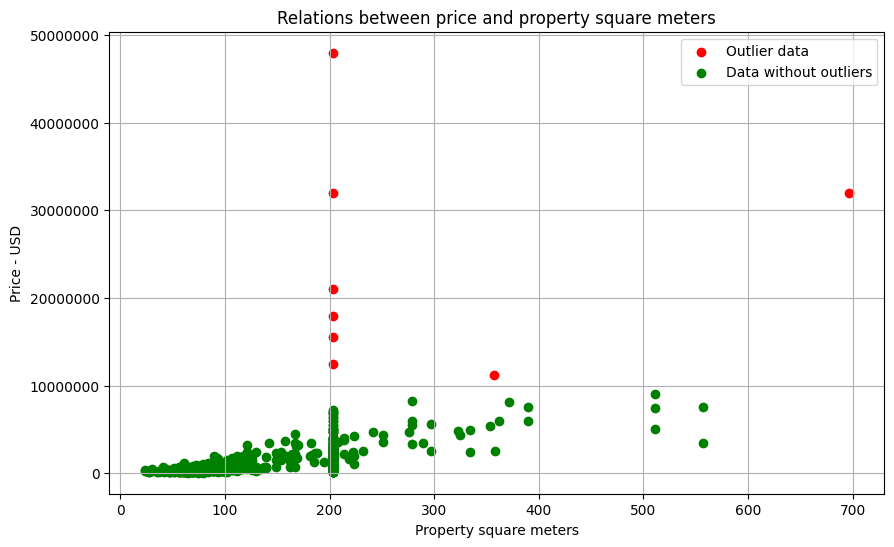

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(df.loc[outliers_indices, 'PROPERTYSQMETERS'], df.loc[outliers_indices, 'PRICE'], color='red', label='Outlier data')
df_filtered = df.drop(outliers_indices)
plt.scatter(df_filtered['PROPERTYSQMETERS'], df_filtered['PRICE'], color='green', label='Data without outliers')
plt.title('Relations between price and property square meters')
plt.xlabel('Property square meters')
plt.ylabel('Price - USD')
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

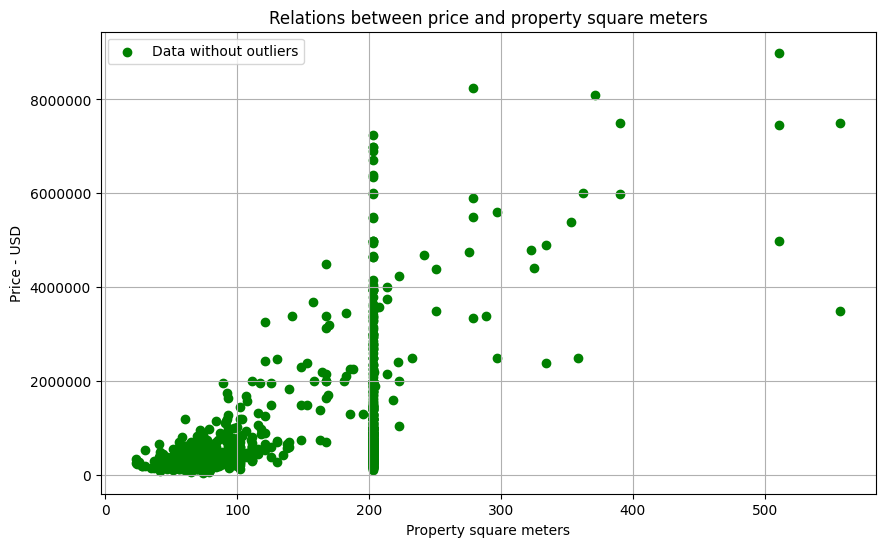

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['PROPERTYSQMETERS'], df_filtered['PRICE'], color='green', label='Data without outliers')
plt.grid(True)
plt.title('Relations between price and property square meters')
plt.xlabel('Property square meters')
plt.ylabel('Price - USD')
plt.legend()
plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### Średnia cena nieruchomości w konkretnej dzielnicy

In [40]:
av_prices

,STATE,AVERAGE PRICE - USD
0,BRONX,"286,139.89"
1,BROOKLYN,"456,990.21"
2,MANHATTAN,"1,973,630.90"
3,STATEN ISLAND,"333,625.00"


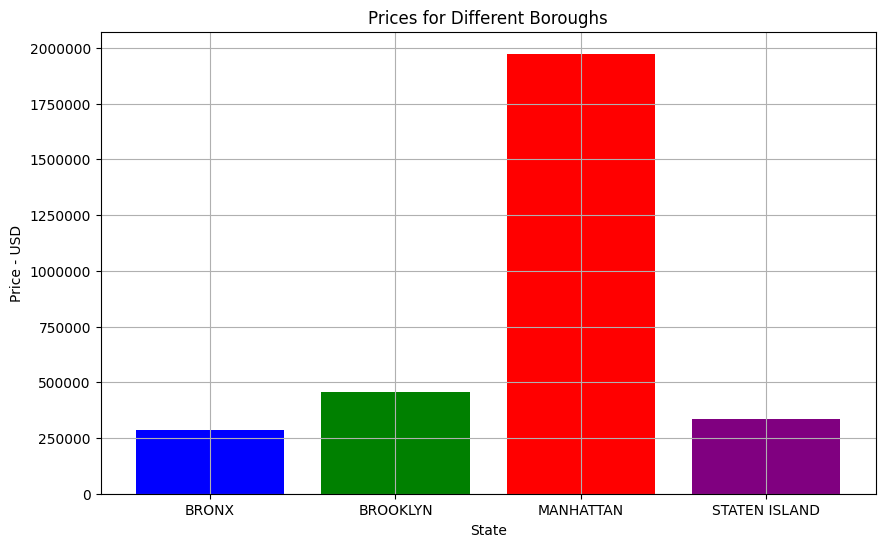

In [43]:
plt.figure(figsize=(10, 6))
plt.bar(average_prices['STATE'], average_prices['AVERAGE PRICE - USD'], color=['blue', 'green', 'red', 'purple'])
plt.xlabel('State')
plt.ylabel('Price - USD')
plt.title('Prices for Different Boroughs')
plt.grid()
plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### Stosunek ilości pomieszczeń do ceny za metr kwadratowy nieruchomości

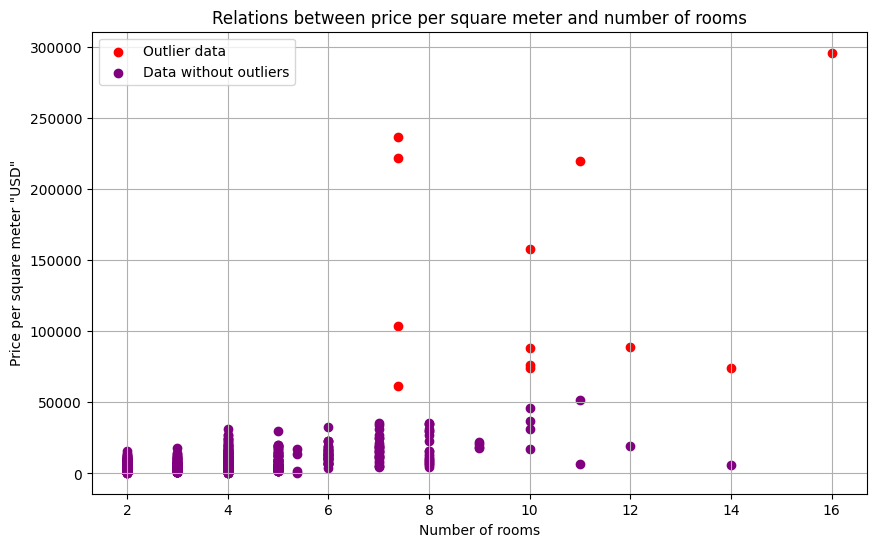

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(df_room.loc[outliers_price, 'TOTAL_ROOMS'], df_room.loc[outliers_price, 'DIVIDE_PRICETOSQ'], color='red', label='Outlier data')
plt.scatter(df_filt['TOTAL_ROOMS'], df_filt['DIVIDE_PRICETOSQ'], color='purple', label='Data without outliers')
plt.title('Relations between price per square meter and number of rooms')
plt.xlabel('Number of rooms')
plt.ylabel('Price per square meter "USD"')
plt.legend()
plt.grid(True)
plt.show()

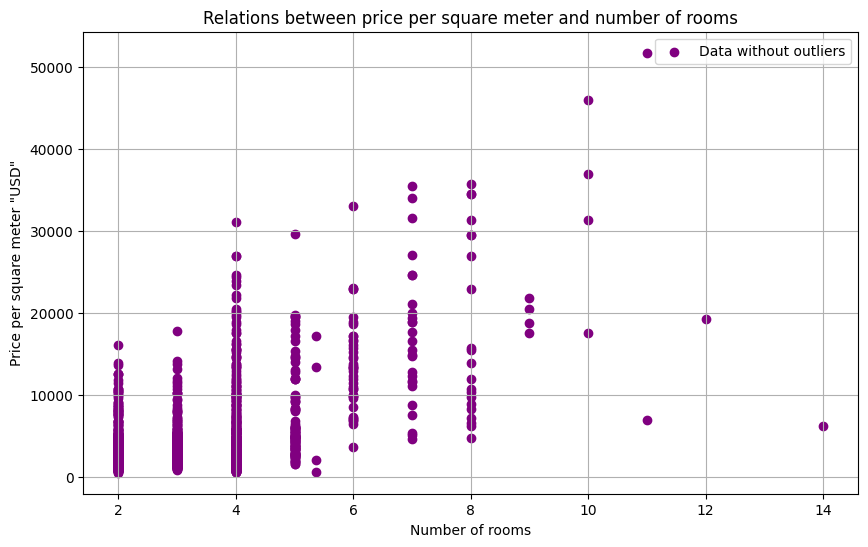

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filt['TOTAL_ROOMS'], df_filt['DIVIDE_PRICETOSQ'], color='purple', label='Data without outliers')
plt.grid(True)
plt.title('Relations between price per square meter and number of rooms')
plt.xlabel('Number of rooms')
plt.ylabel('Price per square meter "USD"')
plt.legend()
plt.show()

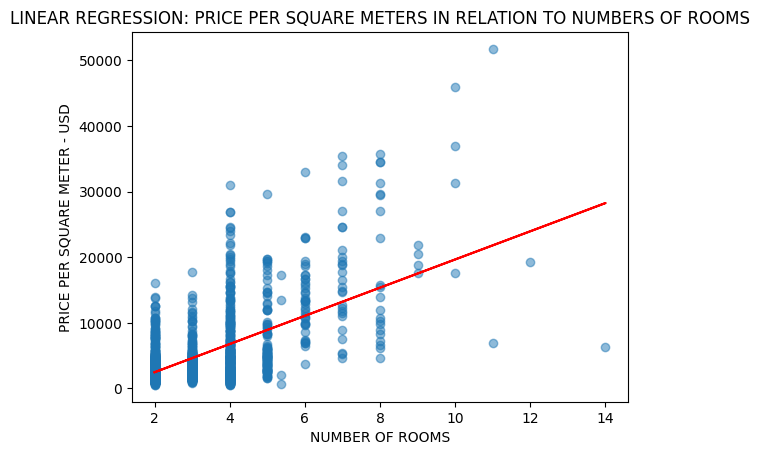

In [37]:
plt.scatter(X['TOTAL_ROOMS'], Y, alpha=0.5)
plt.plot(X['TOTAL_ROOMS'], model.predict(X), color='red')
plt.title('LINEAR REGRESSION: PRICE PER SQUARE METERS IN RELATION TO NUMBERS OF ROOMS')
plt.xlabel('NUMBER OF ROOMS')
plt.ylabel('PRICE PER SQUARE METER - USD')
plt.show()

In [38]:
filt_data.columns = ['PRICE PER SQUARE METERS - USD', 'NUMBER OF ROOMS']
filt_data

,PRICE PER SQUARE METERS - USD,NUMBER OF ROOMS
STATE,,
MANHATTAN,10129.41,4.07
BROOKLYN,4607.82,2.88
BRONX,2832.62,3.03
STATEN ISLAND,3651.39,2.50


#### Mapa Nowego Jorku

In [39]:
nyc_map

### Wnioski

1. Podczas analizy nieruchomości 'CO-OP FOR SALE' możemy dostrzec, iż istnieje 421 mieszkań o dokładnej powierzchni 202.92 m² (2184.207862sqft) . Tak precyzyjny wynik może wskazywać na pewne oszacowanie wartości, co sugeruje obecność ludzkiej ręki w procesie zbierania danych.
2. Manhattan wyróżnia się jako dzielnica o najwyższych średnich cenach nieruchomości, możemy to zauważyć również na mapie - większość kółek czerwonych, które określają cenę nieruchomości powyżej 5mln USD znajduje się na Manhattanie. Jest to zgodne z popularnym przekonaniem o wysokim koszcie życia w tym rejonie Nowego Jorku. Brooklyn, mimo że ma niższe ceny niż Manhattan, przewyższa kolejne dzielnice pod względem średniej ceny. Najtańsze nieruchomości możemy znaleźć w dzielnicy Bronx - na co może mieć wpływ zła sława tej dzielnicy.
3. Analizując stosunek ceny za metr kwadratowy do średniej ceny w danej dzielnicy, zauważamy pewne rozbieżności w liczbie rekordów, co może wskazywać na niezgodność nazw dzielnic z przypisanymi im kodami pocztowymi.
4. Na podstawie przeprowadzonej analizy regresji liniowej można stwierdzić, że istnieje pozytywna zależność między ceną za metr kwadratowy nieruchomości a liczbą pomieszczeń w nieruchomości. Im więcej pomieszczeń znajduje się w nieruchomości, tym wyższa jest cena za metr kwadratowy.
5. Najwyższa cena za metr kwadratowy jest w dzielnicy Manhattan, gdzie wynosi średnio około 10129.41 USD, najniższa cena za metr kwadratowy jest w dzielnicy Bronx, gdzie wynosi średnio około 2832.62 USD.
6. Średnia liczba pomieszczeń jest najwyższa w dzielnicy Manhattan, gdzie wynosi około 4.07 pomieszczenia na nieruchomość, najniższa średnia liczba pomieszczeń jest w dzielnicy Staten Island, gdzie wynosi około 2.5 pomieszczenia na nieruchomość.
7. Możemy zauważyć że co najmniej do jedenego z adresów zostały podane złe współrzędne, wykraczają poza analizowane dzielnice (Manhattan, Brooklyn, Bronx, Staten Island).
8. Najdroższe nieruchomości znajdują się na Manhattanie w najbliższym sąsiedztwie Central Parku oraz w SOHO - okolicy pełnej butików znanych projektantów, luksusowych sklepów i eleganckich galerii.

### Problemy oraz spostrzeżenia

1. Podczas analizy zauważyłem że część nieruchomości nie została należycie przypisana do dzielnić w której się znajduje - należałoby w przyszłości wykluczyć ewentualne spacje oraz pozamieniać nazewnictwo dzielnicy np. nieruchomość z kolumny "STATE" o adresie "New York, NY 10019" - ta nieruchomość położona jest na Manhattanie.
2. Przy bardziej rozbudowanej analizie należałoby wziąć wszystkie rekordy które się znajdują w datasecie, stworzyć coś na zasadzie listy w której konkretnie określalibyśmy typ nieruchomości który nas interesuje.
3. Należałoby stworzyć wybieranie nieruchomości za pomocą suwaka którym określilibyśmy cenę jaka nas interesuje i tylko to graficznie nanieść na mapę.